### Open File

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df) 

Good    0.831582
Bad     0.168418
Name: Category, dtype: float64

In [7]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

### Balance Nationalities and / or Categories

In [8]:
def balance_df(Balance_Nationality, Balance_Category):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = 20000
            if len(nationality) < 20000:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [9]:
df_model = balance_df(Balance_Nationality=False, Balance_Category=True)
df_model.shape

(172618, 78)

### Prepare Data to run Models

In [10]:
x_categorical = ['Review_Month', 'City', 'Pet', 'Purpose', 'Whom', 'Room_Recode', 'Nationality_Recode', 'Length_Recode',
                 'Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [11]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [12]:
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [13]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

In [14]:
X.shape, y.shape

((172618, 67), (172618,))

Split into Train and Test

## MODELS

### Evaluate Model

In [15]:
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score

In [16]:
def evaluate(size, model):
    clf = model
    clf.fit(X_train, y_train)
    train = clf.predict(X_train)
    pred = clf.predict(X_test)
    return(accuracy_score(pred, y_test))

### Select Sample

In [18]:
from sklearn.model_selection import train_test_split
import random

sizes = [1000, 5000, 10000, 25000, 50000, 75000, 100000, 125000, 150000]
universe = list(X.index)
models = [DecisionTreeClassifier(max_depth=4, random_state=1), 
          LogisticRegression(max_iter=500, random_state=1),
          RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)
         ]

acc_mean = []
for model in models:
    accuracies = []
    for i in range(25):
        tmp = []
        for size in sizes:
            sample = random.sample(universe, size)
            X_size = X.loc[sample, :]
            y_size = y[sample]
            X_train, X_test, y_train, y_test = train_test_split(X_size, y_size, test_size=0.8, random_state=100)
            tmp.append(evaluate(size, model))
        accuracies.append(tmp)
    acc_mean.append(np.mean(accuracies, axis=0)) 

<IPython.core.display.Javascript object>


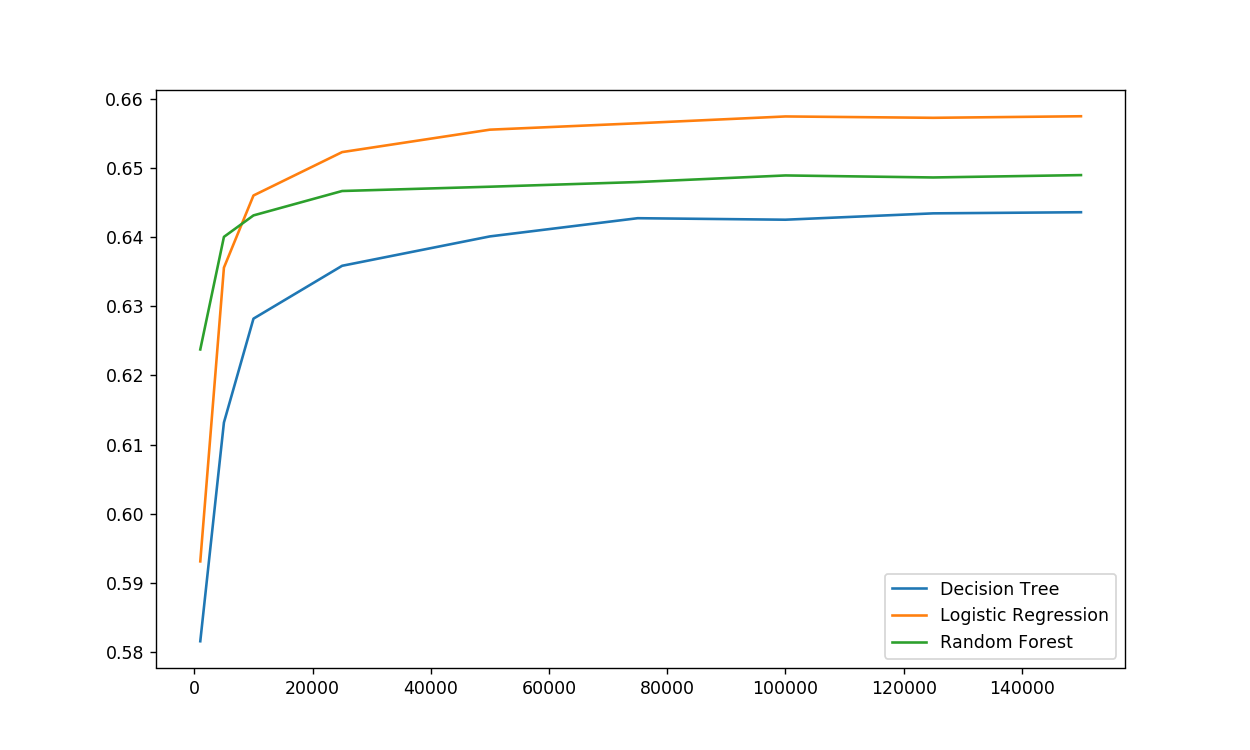

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sizes, acc_mean[0], label = 'Decision Tree')
ax.plot(sizes, acc_mean[1], label = 'Logistic Regression')
ax.plot(sizes, acc_mean[2], label = 'Random Forest')
ax.legend()

In [20]:
pd.DataFrame(acc_mean, columns = sizes, index=['DT','LR','RF'])

,1000,5000,10000,25000,50000,75000,100000,125000,150000
DT,0.58155,0.61318,0.628205,0.635850,0.640098,0.642731,0.642512,0.643431,0.643595
LR,0.59310,0.63558,0.646015,0.652290,0.655534,0.656460,0.657445,0.657248,0.657474
RF,0.62375,0.64003,0.643135,0.646664,0.647284,0.647960,0.648914,0.648622,0.648965
